# TensorFlow Assignment: Playing with GANs

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Matthew Epland

### Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
# for reproducibility
tf.set_random_seed(7)
np.random.seed(7)

## Improve visualize_row() to handle both cases and display better

In [3]:
def visualize_row(images, img_width=28, cmap='gray'):
    im_shape = images.shape
    if len(im_shape) != 2:
        raise ValueError('visualize_row does not work for just one image, needs a row...') 

    im_n = im_shape[0]
    im_len = im_shape[1]
        
    use_label = False
    if im_len != img_width*img_width:
        use_label = True
        label_len = im_len - img_width*img_width
        images, labels = np.split(images, [-label_len], axis=1)

    fig, axs = plt.subplots(1, im_n, sharex=False, sharey=True)
    fig.patch.set_facecolor('white')

    for n in range(im_n):
        im = np.reshape(images[n], [-1, img_width])
        axs[n].imshow(im, cmap=cmap)
        axs[n].set(adjustable='box-forced', aspect='equal')
        axs[n].get_xaxis().set_visible(False)
        axs[n].get_yaxis().set_visible(False)

        if use_label:
            axs[n].set_title('{0:d}'.format(np.argmax(labels[n])), fontsize=30)

    fig_side_len = 8 # Just trying to make them a bit larger
    fig.set_size_inches(fig_side_len, im_n*fig_side_len)

    plt.show()

## Setup code from class
Add 1e7 fudge factor for logs and slightly increase iterations - Otherwise, keep the rest of the GAN code from in class the same

In [4]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
def variables_from_scope(scope_name):
    """
    Returns a list of all variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

In [7]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784
# Training parameters
batch_size = 50
iterations = 30000

In [8]:
# needed to prevent nan errors in logs
log_fudge = 1e-7

In [9]:
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, activation=tf.sigmoid)
    return fake_X

def discriminator(images):
    hidden_layer = tf.layers.dense(images, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

In [10]:
tf.reset_default_graph()
tf.set_random_seed(7)

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables()
    d_on_real = discriminator(real_X)

g_loss = -tf.reduce_mean(tf.log(d_on_fake+log_fudge))
d_loss = -tf.reduce_mean(tf.log(d_on_real+log_fudge) + tf.log(1. - (d_on_fake+log_fudge)))

optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))

initialize_all = tf.global_variables_initializer()

Iter [       0] Time [0.1748] d_loss [1.6711]


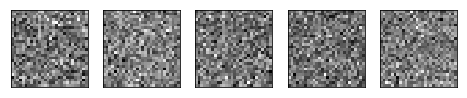

Iter [   10000] Time [41.9062] d_loss [0.7609]


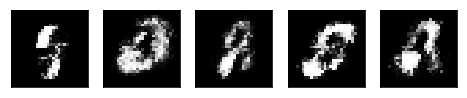

Iter [   20000] Time [80.6588] d_loss [1.1155]


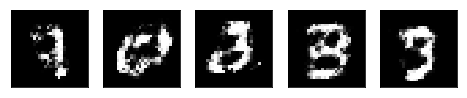

Iter [   29999] Time [121.3565] d_loss [0.8851]


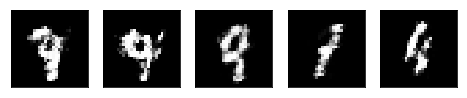

In [11]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(optimize_g, feed_dict=next_feed_dict())
    _, loss = sess.run([optimize_d, d_loss], feed_dict=next_feed_dict())

    if t % 10000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:5])

# Interpolating between images

As our “random noise” varies, so does the image our GAN generates. Perturbing the random input a little bit should perturb the image a little bit. This means that by taking small steps from one input to another, we can “animate” the transition from the image our GAN draws for the first to the one it draws for the second. Generate two random samples from a GAN, and interpolate between them (with, say, 100 steps).

In particular:
1. Train a GAN (using code from class).
2. Generate some noise `= np.random.uniform(-1, 1, [10, 32])` (for instance).
3. Get some fake images out using `sess.run(fake_X, {z: noise})`
4. Visualize them using `visualize_row()` and choose two images you like (say, image 1 and 3). Pull out `start` and `end` noise vectors (e.g., `start = noise[0]` and `end = noise[2]`).
5. Generate a list of ten vectors `steps = [..., ..., ...]`, where entry `i` is `i*10`% of the way from start to end.
6. `np.concatenate(steps)` (with appropriate axis) to get a new noise matrix. Run the GAN on that noise matrix, and visualize the 10 images you get as results.

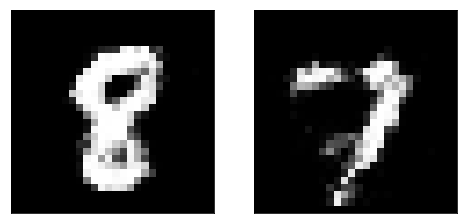

In [15]:
np.random.seed(3) # for reproducibility, picked for good example images
noise = np.random.uniform(-1, 1, [10, z_dimension])
fake_data = sess.run(fake_X, feed_dict={z: noise})
# visualize_row(fake_data)
start_n = 3
stop_n = 4
visualize_row(fake_data[start_n:stop_n+1])

In [16]:
start = noise[start_n]
end = noise[stop_n]
delta = end - start
steps = [start + i*0.1*delta for i in range(10)]
noise_stepped = np.concatenate(steps, axis=0).reshape(10,z_dimension)

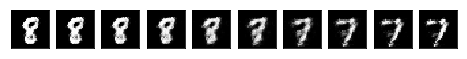

In [17]:
fake_data_stepped = sess.run(fake_X, feed_dict={z: noise_stepped})
visualize_row(fake_data_stepped)

# Conditioning on the class label

In class, we drew a random noise vector $z$, and passed it into the Generator. This gave us very little control over the images we generated. Suppose we wanted to be able to generate a random image of a two, or of a three. In other words, we want to train the model to know how to draw whatever digit we tell it to. How could you alter the training procedure to make this work? Implement a conditional GAN, and use it to generate twos or threes.

In particular,

1. Modify the code from class to take placeholder inputs (real images and z values) that are 10 elements longer.
2. Modify the next_feed_dict to concatenate labels (one-hot, ten-dimensional) to the noise inputs and image inputs.
3. Train the GAN.
4. Try making the GAN generate a few ones, then a few threes, by concatenating `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]` or `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, say, to your noise vectors. How does it do?

In [18]:
labels_size = 10
from keras.utils import to_categorical

Using TensorFlow backend.


In [19]:
tf.reset_default_graph()
tf.set_random_seed(7)

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size+labels_size])
z = tf.placeholder(tf.float32, [None, z_dimension+labels_size])

_, z_label = tf.split(z, [z_dimension, labels_size], 1)

# Generator
with tf.variable_scope("generator") as scope:
    fake_X_im = generator(z)

    # add original labels from z
    fake_X = tf.concat([fake_X_im, z_label], 1)
    
# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables()
    d_on_real = discriminator(real_X)

g_loss = -tf.reduce_mean(tf.log(d_on_fake+log_fudge))
d_loss = -tf.reduce_mean(tf.log(d_on_real+log_fudge) + tf.log(1. - (d_on_fake+log_fudge)))

optimize_d = tf.train.AdamOptimizer().minimize(d_loss, var_list=variables_from_scope("discriminator"))
optimize_g = tf.train.AdamOptimizer().minimize(g_loss, var_list=variables_from_scope("generator"))

initialize_all = tf.global_variables_initializer()

In [20]:
def make_noise():
    noise = np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])
    noise_labels = np.random.randint(low=0, high=9, size=batch_size)
    noise_labels_one_hot = to_categorical(noise_labels, num_classes=labels_size)
    
    return np.concatenate((noise, noise_labels_one_hot), axis=1)

def next_feed_dict():
    batch = mnist.train.next_batch(batch_size)

    return {real_X: np.concatenate((batch[0], batch[1]), axis=1),
            z:      make_noise()}

Iter [       0] Time [0.0919] d_loss [2.1686]


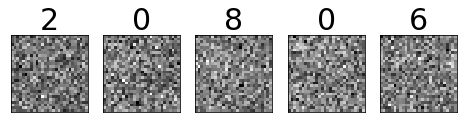

Iter [   10000] Time [45.9247] d_loss [0.6475]


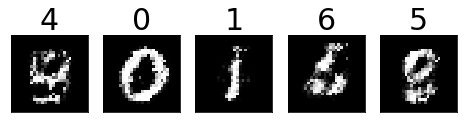

Iter [   20000] Time [89.1220] d_loss [0.8725]


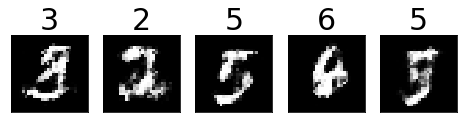

Iter [   29999] Time [141.8929] d_loss [0.9437]


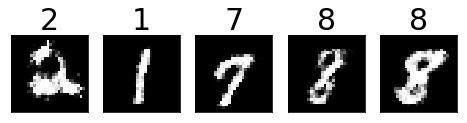

In [21]:
# Train the GAN.
sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(optimize_g, feed_dict=next_feed_dict())
    _, loss = sess.run([optimize_d, d_loss], feed_dict=next_feed_dict())

    if t % 10000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:5])

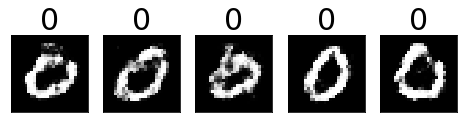

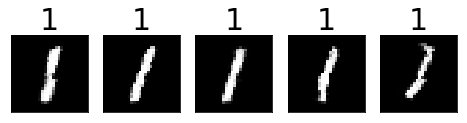

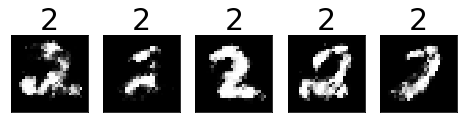

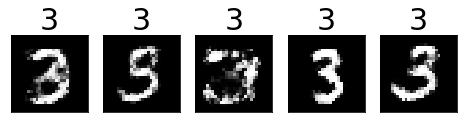

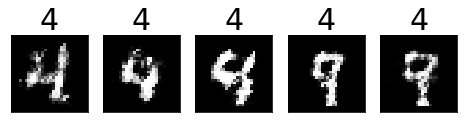

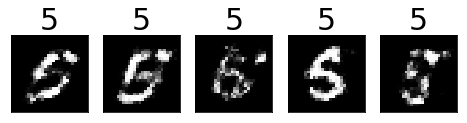

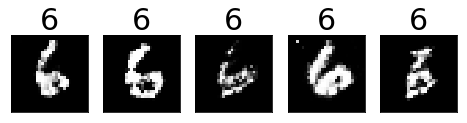

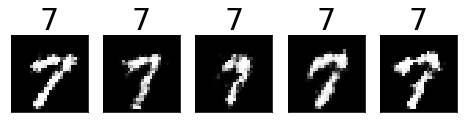

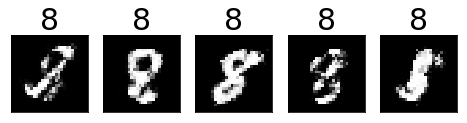

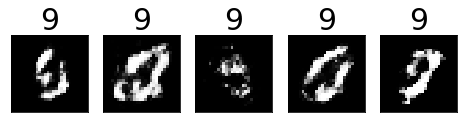

In [22]:
np.random.seed(2) # for reproducability
n_per_label = 5

for label in range(labels_size):
    noise = np.random.uniform(-1, 1, [n_per_label, z_dimension])
    noise_labels_one_hot = to_categorical(label*np.ones(n_per_label), num_classes=labels_size)

    noise = np.concatenate((noise, noise_labels_one_hot), axis=1)
    
    fake_data = sess.run(fake_X, feed_dict={z: noise})
    visualize_row(fake_data)